In [1]:
# Setting import path
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'quantum_optimization'))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from import_stocks import read_stock_symbols
from get_stocks_data import get_yahoo_data, get_stocks_dataframe
from get_optimal_stocks import get_optimal_stocks
from solver import solve_using_numpy_minimum_eigensolver
from visualizer import print_result, display_stocks_graph
from portfolio import define_portfolio_optimization_problem

#### Get Yahoo Finance Data

In [3]:
# Define the base path relative to the current working directory
base_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'assets'))
stocks_symbol_list_path = os.path.join(base_path, 'nasdaq_100_stocks.csv')


######### Define no of stocks ###############3
no_of_stocks = 6


stocks = read_stock_symbols(stocks_symbol_list_path, num_symbols=no_of_stocks)
start_date=(2018, 1, 1)
end_date=(2020, 1, 1)

data, tickers, mu, sigma = get_yahoo_data(stocks, start_date, end_date)

print("Stocks: ", stocks)
print("Mean return: ", mu)
print("Covariance: ", sigma)

Stocks:  ['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'NVDA']
Mean return:  [0.00127331 0.00139123 0.00058917 0.00057577 0.00105956 0.00075576]
Covariance:  [[0.00030072 0.00017684 0.00017932 0.00017642 0.00020524 0.00026963]
 [0.00017684 0.00023657 0.00018949 0.00018884 0.00022097 0.00026415]
 [0.00017932 0.00018949 0.00027228 0.00026919 0.00021745 0.00026808]
 [0.00017642 0.00018884 0.00026919 0.00026873 0.00021548 0.00026709]
 [0.00020524 0.00022097 0.00021745 0.00021548 0.00036201 0.00032911]
 [0.00026963 0.00026415 0.00026808 0.00026709 0.00032911 0.00080826]]


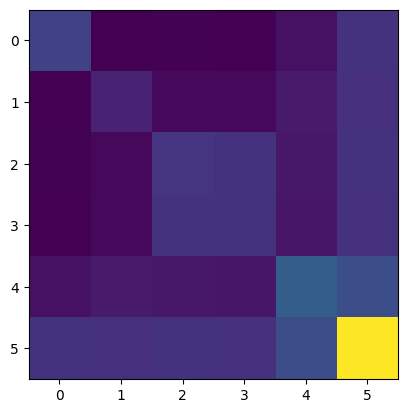

In [4]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

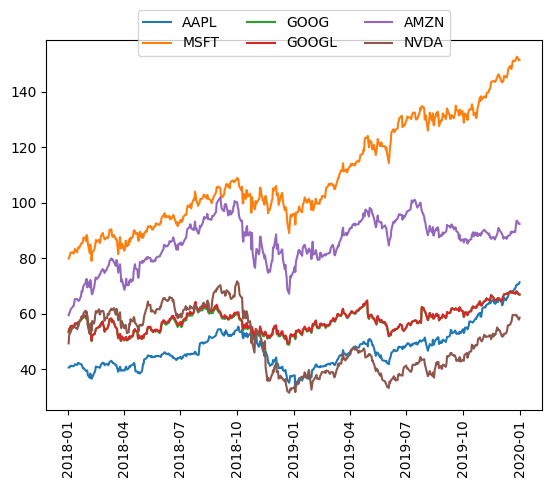

In [5]:
display_stocks_graph(data)

### Define Portfolio Optimization Problem

In [6]:
q = 0.5  # set risk factor
budget = 3  # set budget

portfolio, portfolio_quadratic_program = define_portfolio_optimization_problem(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)
print("Portfolio Quadratic Program: ", portfolio_quadratic_program)

Portfolio Quadratic Program:  minimize 0.0001503605298689868*x_0^2 + 0.00017683586589311974*x_0*x_1 + 0.00017932041178414445*x_0*x_2 + 0.00017641940497736952*x_0*x_3 + 0.00020524291509918318*x_0*x_4 + 0.00026963471178291195*x_0*x_5 + 0.00011828307601826574*x_1^2 + 0.00018949236257752484*x_1*x_2 + 0.00018884383223897398*x_1*x_3 + 0.00022096604383588892*x_1*x_4 + 0.0002641529147157466*x_1*x_5 + 0.00013614208488725064*x_2^2 + 0.0002691932746040337*x_2*x_3 + 0.00021744609204961274*x_2*x_4 + 0.00026808257603396917*x_2*x_5 + 0.00013436266419996728*x_3^2 + 0.0002154780313894813*x_3*x_4 + 0.0002670930796149853*x_3*x_5 + 0.00018100406096977167*x_4^2 + 0.00032911356334743713*x_4*x_5 + 0.00040412754125884867*x_5^2 - 0.0012733081169233136*x_0 - 0.0013912263432622133*x_1 - 0.000589172999480696*x_2 - 0.0005757652860410011*x_3 - 0.0010595567458522577*x_4 - 0.0007557635335737751*x_5 (6 variables, 1 constraints, 'Portfolio optimization')


### Solve the portfolio optimization problem

#### Solve using NumPyMinimumEigensolver (as a classical reference)

In [7]:
result = solve_using_numpy_minimum_eigensolver(portfolio_quadratic_program)

print_result(stocks, portfolio, result)

Optimal: selection [1. 1. 0. 0. 1. 0.], value -0.0027
Optimal Companies: ['AAPL', 'MSFT', 'AMZN']

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 0 1 0]	-0.0027		1.0000


In [8]:
Portfolio_total_value = 1000000 # This is in dollar

# Define the stock symbols (Yahoo Finance uses different symbols compared to Quandl)
stock_symbols = get_optimal_stocks(tickers, result) # Default :['JPM', 'C', 'BAC', 'WFC']
stock_data = get_stocks_dataframe(stock_symbols, start_date, end_date)


# Generate random allocations
allocations = np.random.rand(len(stock_symbols))
print(allocations)
# Normalize allocations so they add up to 1
allocations /= allocations.sum()

# Calculate and add position values to each dataframe
for stock_symbol, allocation in zip(stock_symbols, allocations):
    stock_df = stock_data[stock_symbol]
    stock_df['Allocation'] = stock_df['Normed Return'] * allocation
    stock_df['Position Values'] = stock_df['Allocation'] * Portfolio_total_value

# Display the head of the JPM dataframe with allocation and position values
print("\n DataFrame with Allocation and Position Values Head:")
print(stock_data[stock_symbols[0]].head())

# Combine the position values into a single DataFrame and calculate the total position
portfolio_val = pd.concat([stock_data[symbol]['Position Values'] for symbol in stock_symbols], axis=1)
portfolio_val.columns = [f"{symbol} Pos" for symbol in stock_symbols]
portfolio_val['Total Pos'] = portfolio_val.sum(axis=1)

# Display the head of the portfolio valuation DataFrame
print("\nPortfolio Valuation DataFrame Head:")
print(portfolio_val.head())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

[0.84995582 0.11858592 0.65509248]

 DataFrame with Allocation and Position Values Head:
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2018-01-02  42.540001  43.075001  42.314999  43.064999  40.615894  102223600   
2018-01-03  43.132500  43.637501  42.990002  43.057499  40.608810  118071600   
2018-01-04  43.134998  43.367500  43.020000  43.257500  40.797436   89738400   
2018-01-05  43.360001  43.842499  43.262501  43.750000  41.261940   94640000   
2018-01-08  43.587502  43.902500  43.482498  43.587502  41.108673   82271200   

            Normed Return  Allocation  Position Values  
Date                                                    
2018-01-02       1.000000    0.523490    523489.719856  
2018-01-03       0.999826    0.523398    523398.417051  
2018-01-04       1.004470    0.525830    525829.569333  
2018-01-05       1.015906    0.531816    531816.466816  
2018-01-

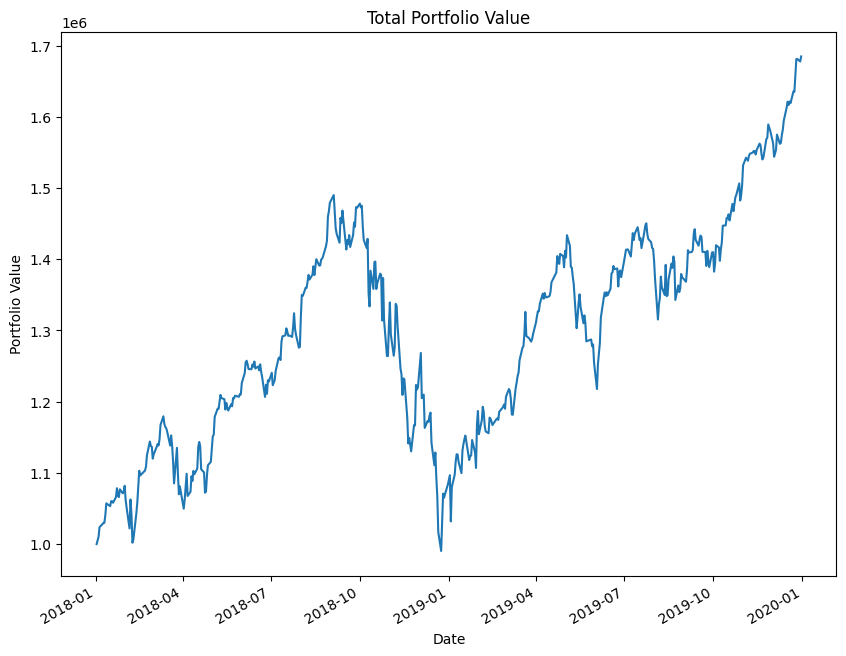

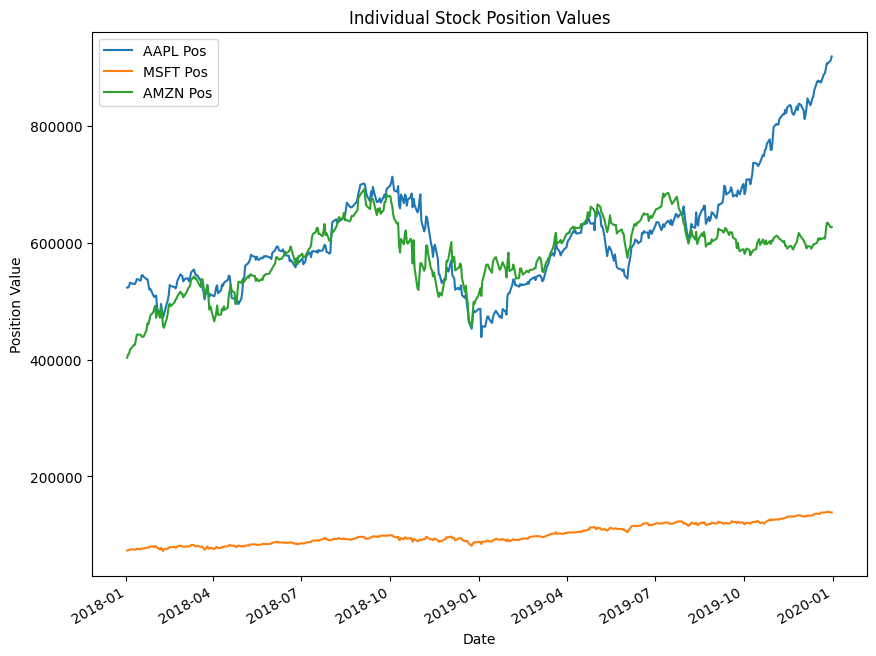

,AAPL Pos,MSFT Pos,AMZN Pos,Total Pos,Daily Return
Date,,,,,
2018-01-02,523489.719856,73037.334700,403472.945444,1.000000e+06,NaN
2018-01-03,523398.417051,73377.235598,408627.437553,1.005403e+06,0.005403
2018-01-04,525829.569333,74023.068217,410456.459234,1.010309e+06,0.004880
2018-01-05,531816.466816,74940.807612,417090.468541,1.023848e+06,0.013400
2018-01-08,529841.041889,75017.278343,423106.864594,1.027965e+06,0.004022
...,...,...,...,...,...
2019-12-24,890026.820820,138062.920827,607141.944951,1.635232e+06,-0.000285
2019-12-26,907685.186428,139194.562171,634139.431654,1.681019e+06,0.028001
2019-12-27,907340.821946,139448.985940,634488.936137,1.681279e+06,0.000154


In [9]:
# Plot the total portfolio value
portfolio_val['Total Pos'].plot(figsize=(10, 8))
plt.title('Total Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()

# Plot the individual stock position values
portfolio_val.drop('Total Pos', axis=1).plot(kind='line', figsize=(10, 8))
plt.title('Individual Stock Position Values')
plt.xlabel('Date')
plt.ylabel('Position Value')
plt.show()


portfolio_val['Daily Return'] = portfolio_val['Total Pos'].pct_change(1)
portfolio_val

In [10]:
# Calculate the cumulative return
cum_ret = 100 * (portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0] - 1)
print('Our cumulative return is {} percent!'.format(cum_ret))

Our cumulative return is 68.47756062321844 percent!


/tmp/ipykernel_14876/4253317811.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_ret = 100 * (portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0] - 1)


In [11]:
portfolio_val['Daily Return'].mean()

0.0011682021054135628

In [12]:
portfolio_val['Daily Return'].std()

0.01603970752576515

In [13]:
SR = portfolio_val['Daily Return'].mean()/portfolio_val['Daily Return'].std()
SR

0.07283188322087783

In [14]:
ASR = (252**0.5)*SR
ASR

1.156170303113644

In [15]:
# Extract and combine the adjusted close prices into a single DataFrame for daily returns
close_data = {symbol: stock_data[symbol]['Adj Close'] for symbol in stock_symbols}

# Combine daily close prices into a single DataFrame
stocks = pd.DataFrame(close_data)

# Display the head of the daily returns DataFrame
print("\nDaily Returns DataFrame Head:")
print(stocks.head())

# Calculate logarithmic returns
log_ret = np.log(stocks / stocks.shift(1))

# Display the head of the logarithmic returns DataFrame
print("\nLogarithmic Returns DataFrame Head:")
print(log_ret.head())


Daily Returns DataFrame Head:
                 AAPL       MSFT       AMZN
Date                                       
2018-01-02  40.615894  79.936729  59.450500
2018-01-03  40.608810  80.308739  60.209999
2018-01-04  40.797436  81.015579  60.479500
2018-01-05  41.261940  82.020012  61.457001
2018-01-08  41.108673  82.103706  62.343498

Logarithmic Returns DataFrame Head:
                AAPL      MSFT      AMZN
Date                                    
2018-01-02       NaN       NaN       NaN
2018-01-03 -0.000174  0.004643  0.012694
2018-01-04  0.004634  0.008763  0.004466
2018-01-05  0.011321  0.012322  0.016033
2018-01-08 -0.003721  0.001020  0.014322


In [16]:
#calculate the log return mean of each stock
log_ret.mean() * 252

AAPL    0.282721
MSFT    0.320657
AMZN    0.221326
dtype: float64

In [17]:
# Compute pairwise covariance of columns
log_ret.cov()*252

,AAPL,MSFT,AMZN
AAPL,0.076300,0.044668,0.051801
MSFT,0.044668,0.059527,0.055720
AMZN,0.051801,0.055720,0.091403


In [18]:
######## Trying one iteration ################

np.random.seed(101)

# Stock Columns
print('Stocks')
print(stocks.columns)
print('\n')

# Create Random Weights
print('Creating Random Weights')
weights = np.array(np.random.random(len(stock_symbols))) # changes to be done here 
print(weights)
print('\n')

# Rebalance Weights
print('Rebalance to sum to 1.0')
weights = weights / np.sum(weights)
print(weights)
print('\n')

# Expected Return
print('Expected Portfolio Return')
exp_ret = np.sum(log_ret.mean() * weights) *252
print(exp_ret)
print('\n')

# Expected Variance
print('Expected Volatility')
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
print(exp_vol)
print('\n')

# Sharpe Ratio
SR = exp_ret/exp_vol
print('Sharpe Ratio')
print(SR)

Stocks
Index(['AAPL', 'MSFT', 'AMZN'], dtype='object')


Creating Random Weights
[0.51639863 0.57066759 0.02847423]


Rebalance to sum to 1.0
[0.46291341 0.51156154 0.02552505]


Expected Portfolio Return
0.3005606999157036


Expected Volatility
0.2362676152023489


Sharpe Ratio
1.272119751402627


In [19]:
################## For multiple iteration : Monte Carlo ##########################3
num_ports = 5000

all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(len(stock_symbols))) # Change to be made here 

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]


In [20]:
Max_sharpe =sharpe_arr.max()
print('Max sharpe ratio in array :', Max_sharpe)

Max sharpe ratio in array : 1.3269865336106152


In [21]:
arr_sharpe = sharpe_arr.argmax()
print('Max sharpe ratio index :', arr_sharpe)

Max sharpe ratio index : 3270


In [22]:
all_weights[arr_sharpe,:]


weight_list = all_weights
print(weight_list[0])


print(f'Values to be invested in each stock for portfolio of value {Portfolio_total_value} $')
for i in range(len(stock_symbols)):
    print(f'{stock_symbols[i]} : ${weight_list[0][i]* Portfolio_total_value} ')



[0.10145035 0.40532253 0.49322711]
Values to be invested in each stock for portfolio of value 1000000 $
AAPL : $101450.35351927289 
MSFT : $405322.53233710217 
AMZN : $493227.1141436249 


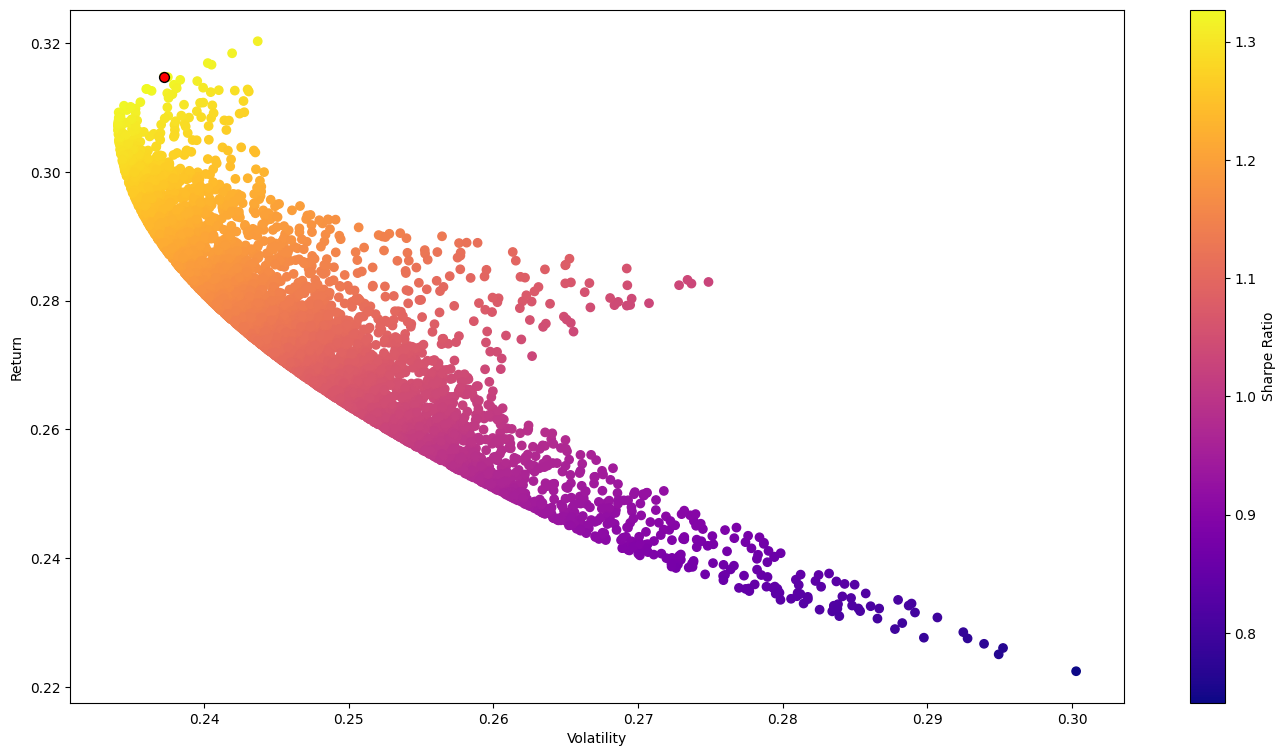

In [23]:
max_sr_ret = ret_arr[arr_sharpe]
max_sr_vol = vol_arr[arr_sharpe]
plt.figure(figsize=(17,9))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')